In [1]:
import sys
sys.path.append('../')
sys.path.append('../support/')
sys.path.append('../lung_segmentation/')

from preprocessing import *
from ct_reader import *
import pandas as pd
from os.path import join, basename, isfile
from scipy.ndimage.interpolation import zoom
from glob import glob
from multiprocessing import Pool
from scipy.ndimage import morphology
from scipy.ndimage import label
from skimage import measure
from tqdm import tqdm
from multiprocessing import Pool
import pickle
%pylab inline
from paths import * 
from skimage.transform import resize
import warnings
# warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


In [2]:
BORDER = 32
BATCH_SIZE = 32
SPACING = array([.9, .7, .7])
UPSIDES = pickle.load(open(join(PATH['WEIGHTS'], 
                                'upsides'), 'rb'))
CPU = 24

In [3]:
def read_ct(path, ret_xy_spacing=False, ret_original_format=True):
    patient = read_ct_scan(path)
    image = get_pixels_hu(patient)
#     image[image == image[0,0,0]] = 0
    
    if ret_original_format:
        return image, patient
    
    if ret_xy_spacing:
        return image, patient.GetSpacing()[0]
    
    return image

In [4]:
def segment_nodules(patch, mask, is_nodule=True, magic_const=50):
    prepared = (patch - patch.min()) / (patch.max() - patch.min())

    kmeans = KMeans(n_clusters=2)
    data = prepared[coords]
    
    if data.shape[0] <= 2:
        return mask
    
    data = kmeans.fit_predict(expand_dims(data, 1))

    kmean = zeros(mask.shape)
    kmean[coords] = data + magic_const
    labels, num = label(kmean, return_num=True, background=0)

    nodule_a = argmax([sum(labels == i) for i in range(1, num + 1)]) + 1
    init = kmeans.predict(expand_dims(prepared[labels == nodule_a], 1)).min()
    nodule_b = list()
    for i in range(1, num + 1):
        if i != nodule_a:
            if kmeans.predict(expand_dims(prepared[where(labels == i)], 1)).min() != init:
                nodule_b.append((sum(labels == i), i))

    nodule_b = max(nodule_b)[1]

    A = prepared[labels == nodule_a]
    B = prepared[labels == nodule_b]

    if mean(A.reshape(-1)) > mean(B.reshape(-1)):
        labels = labels == nodule_a
    else:
        labels = labels == nodule_b

    return labels

In [5]:
def overlap(lung, mask):
#     iso = binary_dilation(imresize(isolated[163], (512, 512)))
    labeled, num = label(mask)
    coords = list()
    for colour in range(1, labeled.max() + 1):
        coords.append(where(labeled == colour))
        
    coordsm = array([[int(coord[0].mean())
                     for coord in coords], 
                    [int(coord[1].mean())
                     for coord in coords],
                    [int(coord[2].mean())
                     for coord in coords]])
        
    coords = array([[int(coord[0].mean() / SPACING[0])
                     for coord in coords], 
                    [int(coord[1].mean() / SPACING[1])
                     for coord in coords],
                    [int(coord[2].mean() / SPACING[2])
                     for coord in coords]])
    
    pads = ((BORDER, BORDER), 
            (BORDER, BORDER), 
            (BORDER, BORDER))
    
    lung = pad(lung, pads, 
               mode='edge')
    labeled = pad(labeled, pads, 
                  mode='edge')
    patches = list()
    masks = list()
    for coord, coordm in zip(coords.T, coordsm.T):
        patches.append(lung[coord[0]: coord[0] + 2 * BORDER,
                            coord[1]: coord[1] + 2 * BORDER,
                            coord[2]: coord[2] + 2 * BORDER])
        
        masks.append(labeled[coordm[0]: coordm[0] + 2 * BORDER,
                             coordm[1]: coordm[1] + 2 * BORDER,
                             coordm[2]: coordm[2] + 2 * BORDER])

    return patches, masks

In [103]:
def operate(path):
    lung, ct_lung = read_ct(path, ret_original_format=True)
    
    lung, spacing = resample(lung, ct_lung, SPACING)
    
    name = basename(path)
    mask = load(join(PATH['DATA_ENHANCED'], 
                     name + '.npy'))
    
#     mask, spacing = resample(mask, (1, 1, 1), SPACING)
    
    if name in UPSIDES:
        lung = flipud(lung)
        mask = flipud(mask)
        
    batch, masks = overlap(lung, mask)
    
    return [patch.astype(int16) for patch in batch], masks

In [7]:
def get_remind_files():
    file_list = set(glob(join(PATH['DATA'], '*')))
#     file_list = file_list.difference(set([join(PATH['DATA'], basename(path).split('.npy')[0][:32]) 
#                             for path in glob(join(PATH['ENHANCED_CROPPED'], '*.npy'))]))
    return sorted(list(file_list))

In [104]:
file_list = get_remind_files()

for counter in range(len(file_list) // BATCH_SIZE + 1):
    
    batch_files = file_list[BATCH_SIZE * counter:
                            BATCH_SIZE * (counter + 1)]
#     with Pool(CPU) as pool:
#         incorrect = pool.map(operate, batch_files)
    batches, masks = operate(batch_files[0])
    break

(195, 512, 512)
(390, 355, 355)
(390, 355, 355)


TypeError: 'NoneType' object is not iterable

In [29]:
masks[0].shape

(64, 64, 64)

In [30]:
batches[10].shape

(64, 64, 64)

In [31]:
lung, ct_lung = read_ct(batch_files[0], ret_original_format=True)
lung, spacing = resample(lung, ct_lung, SPACING)
    
name = basename(batch_files[0])
mask = load(join(PATH['DATA_ENHANCED'], 
                 name + '.npy'))
    
mask, spacing = resample(mask, (1, 1, 1), SPACING)

In [32]:
labeled, num = label(mask)

In [33]:
bincounted = bincount(labeled.flatten())
maxima = sorted(list(zip(bincounted, 
                         arange(bincounted.shape[0]))), 
                reverse=True)[1:]

In [34]:
coord = where(labeled == maxima[7][1])
x = int(coord[0].mean())
y = int(coord[1].mean())
z = int(coord[2].mean())

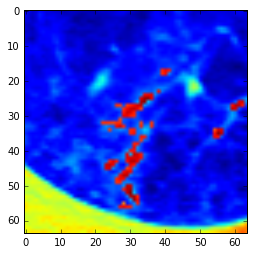

In [35]:
imshow(lung[x, 
            y - BORDER: y + BORDER, 
            z - BORDER: z + BORDER] 
       + 1000 * (labeled[x, 
                         y - BORDER: y + BORDER, 
                         z - BORDER: z + BORDER] != 0))

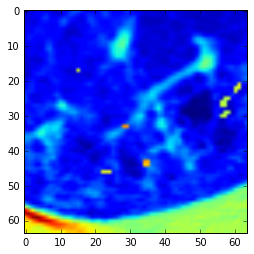

In [67]:
imshow(batches[312][30] + 1000 * (masks[312][30] != 0))

In [37]:
def region_growing(img, seed, minthr, maxthr, structure=None):
    """code was taken from:
    https://github.com/loli/medpy/wiki/Basic-image-manipulation
    """
    img[seed] = minthr
    thrimg = (img <= maxthr) & (img >= minthr)
    lmap, _ = label(thrimg, structure=structure)
    lids = unique(lmap[seed])
    region = zeros(img.shape, numpy.bool)
    for lid in lids:
        region |= lmap == lid
    return region

(array([11, 11, 11, 23, 23, 24, 24, 25, 25, 26, 27, 28, 28, 28, 29, 29, 29,
        30, 31, 32, 32, 33, 33, 33, 33, 34, 34, 34, 34, 35, 44, 44, 44, 44,
        44, 45, 45, 45, 46, 46, 46]),
 array([ 1,  2,  3, 59, 60, 56, 60, 56, 60, 56, 57, 58, 59, 60, 57, 58, 59,
        57, 33, 32, 33, 29, 30, 32, 33, 26, 27, 28, 57, 57, 23, 24, 25, 34,
        35, 22, 24, 35, 22, 23, 24]))

In [102]:
batch_num = 32
mask = masks[32]
batch = batches[32].copy()
interval = [1, 1]
grown = [mask == mask[32][32][32]] * 2
minval = median(batch[grown[-1]])
maxval = median(batch[grown[-1]])
sums = [grown[0].sum()] * 2
while 2 * sums[0] > sums[1]: #unique((mask == mask[32][32]) == grown).shape[0] == 1:
    grown.append(region_growing(batch, 
                                grown[-1], 
                                minval, 
                                maxval))
#     minval -= interval[0]
    maxval += interval[1]
    grown.pop(0)
    sums.append(grown[-1].sum())
    sums.pop(0)
    print(sums[-1])

262052
262052
262052
262052
262052
262052
262052
262052
262052
262052
262052
262052
262052
262052
262052
262052
262052
262052
262052
262052
262052
262052
262052
262052
262052
262052
262052
262052
262052
262052
262052
262052
262052
262052
262052
262052
262052
262052
262052
262052
262052
262052
262052
262052
262052
262052
262052
262052
262052
262052
262052
262052
262052
262052
262052
262052
262052
262052
262052
262053
262053
262053
262053
262053
262053
262053
262054
262054
262054
262054
262054
262054
262054
262055
262055
262055
262055
262055
262055
262055
262055
262055
262055
262056
262056
262056
262056
262056
262056
262056
262056
262056
262056
262056
262056
262056
262056
262056
262056
262056
262056
262056
262056
262056
262056
262056
262056
262056
262056
262056
262056
262056
262056
262056
262056
262056
262056
262056
262056
262056
262056
262056
262056
262056
262056
262056
262056
262056
262056
262056
262056
262056
262056
262056
262056
262056
262056
262056
262056
262056
262056
262056
262056

KeyboardInterrupt: 

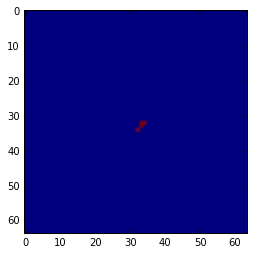

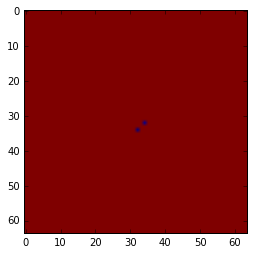

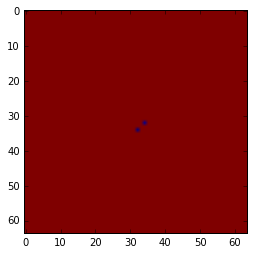

In [101]:
i = 32

plt.imshow(batch[i] + 1000 * (mask[i] > 0))
plt.show()
plt.imshow(batch[i] + 1000 * grown[0][i])
plt.show()
plt.imshow(batch[i] + 1000 * grown[1][i])

In [66]:
unique((masks[312][32] == masks[312][32][32][32]) == grown)

array([ True], dtype=bool)